##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [1]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np

#### Successful 3D gradient ####

X shape:  (100, 100)
Y shape:  (100, 100)
combined data shape:  (100, 100)
color:  (100, 100, 4)
x_new.shape:  (10000,)
color_new.shape:  (10000, 4)


C:\Users\Joshua\AppData\Local\Temp\ipykernel_20440\1435191464.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x_new, y_new, z_new, c=color_new, cmap=custom_cmap, s=50, marker='o')


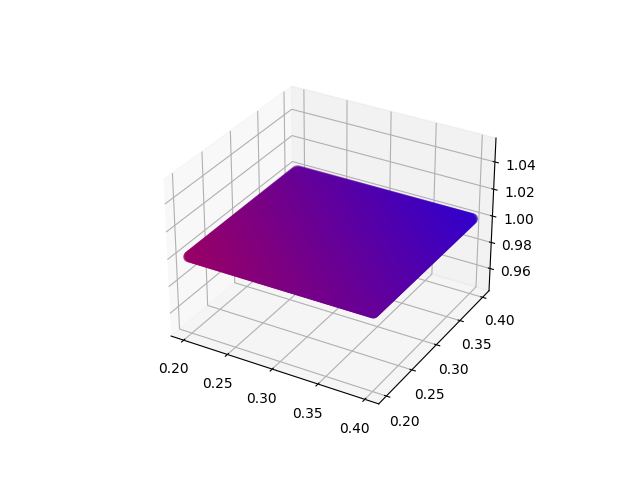

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
lowest_color_value = 0.2
highest_color_value = 0.8
z_value = 1.
x = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)
y = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)
X, Y = np.meshgrid(x, y)

# X = np.pad(X, ((0, 0), (0, 1)), mode='constant', constant_values=z_value/num_dimensions)
# Y = np.pad(Y, ((0, 0), (0, 1)), mode='constant', constant_values=z_value/num_dimensions)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)
# print(X)

# Combine data for both dimensions into a single variable
combined_data = X + Y  # You can use a different combination as needed
print("combined data shape: ", combined_data.shape)
# print(combined_data)
# combined_data = normalize(combined_data, norm='l2', axis=0)
# print(combined_data)
# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)
# color = np.delete(color, -1, axis=-1)
print("color: ", color.shape)
# print(color)
# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# reshape x and y to match what is expected
x_new = X.reshape((-1,))
y_new = Y.reshape((-1,))
z_new = np.full(x_new.shape, z_value)
color_new = color.reshape((-1, 4))
print("x_new.shape: ", x_new.shape)
print("color_new.shape: ", color_new.shape)

# Plot the 3D grid with the colormap representing both dimensions
sc = ax.scatter(x_new, y_new, z_new, c=color_new, cmap=custom_cmap, s=50, marker='o')
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label('Color Gradient')

# Show the plot
plt.show()

#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 